In [1]:
% pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# load functions for data analysis
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols
import statsmodels.formula.api as smf    
import pandas, os, scipy, sys
import seaborn as sns
import numpy as np
pandas.options.mode.chained_assignment = None

In [45]:
# scr data anslysis functions
sys.path.append(os.getcwd() + '/scr/')
from scr_analysis_functions_fyp import experimental
# behavioral analysis functions
sys.path.append(os.getcwd() + '/self_report/')
import behavioral_analysis_functions as behavioral_functions

In [5]:
# paths to scr and behavioral data
scr_data_path =  os.getcwd() + '/scr/data_study_one'
behavioral_data_path = os.getcwd() + '/self_report/data_study_one/'

In [6]:
day_one = experimental(scr_data_path)
day_one.day = 1
day_one.preprocessData()

In [7]:
day_two = experimental(scr_data_path)
day_two.day = 2
day_two.preprocessData()

In [8]:
def counterbalance_info(_data_): 
    
    cb, bc, order = [], [], np.zeros(_data_.nSubjects)

    for iSubject in range(0,len(_data_.subjectNames)): 
        
        if str.find(_data_.subjectNames[iSubject], '_cb_') != -1: cb.append(iSubject)
        else: bc.append(iSubject)
            
    order[cb] = 1
    
    _dict_ = {'counter_balanced_inds':np.array(cb), 
              'not_counter_balanced_inds': np.array(bc), 
              'order': order} 

    return _dict_

In [9]:
def log_transform(_a_): 
    """convenience function"""
    return np.log(1 + _a_)

In [10]:
def extract_conditioning_data(scr_data_, type_ , location_, dict_=''):
    '''
    scr_data_ is either day_one or day_two
    type_ is either 'raw' or 'trans'
    location_ is either 'onset' (predictive) or 'offset' (contagion)
    '''
    
    if not dict_: dict_ = {}
    
    dict_['%s_%s'%(type_, location_)] = {} 
    
    if location_ == 'onset':
        start_ind, end_ind = 4, 13 
        trial_ = list(range(start_ind, end_ind))
        positive_ = np.zeros([scr_data_.nSubjects,len(range(start_ind,end_ind))])
        negative_ = np.zeros([scr_data_.nSubjects,len(range(start_ind,end_ind))])
    else: 
        trial_ = np.array([3, 5, 6, 8, 9, 11])# list(range(start_ind, end_ind))
        positive_ = np.zeros([scr_data_.nSubjects,len(trial_)])
        negative_ = np.zeros([scr_data_.nSubjects,len(trial_)])
    

    
    for i_stim in range(0,len(trial_)):
        positive_[:,i_stim], negative_[:,i_stim] = scr_data_.amplitudeDifference(type_, trial_[i_stim], location_);

    significance_ = np.zeros(scr_data_.nSubjects)
    for iSubject in range(0,scr_data_.nSubjects): 
        significance_[iSubject] = scipy.stats.ttest_ind(positive_[iSubject,:], negative_[iSubject,:])[1];

    dict_['%s_%s'%(type_, location_)]['positive_stim'] = log_transform(positive_)
    dict_['%s_%s'%(type_, location_)]['negative_stim'] = log_transform(negative_)
    dict_['%s_%s'%(type_, location_)]['significe_difference'] = significance_
    dict_['%s_%s'%(type_, location_)]['learning'] = mean(log_transform(positive_) - log_transform(negative_),1)
    
    return dict_

In [11]:
def extract_renewal_data(day_two, type_, location_, dict_=''): 
        
    if not dict_: dict_ = {} 
    dict_['%s_%s'%(type_, location_)] = {} 
        
    plus, minus = day_two.amplitudeDifference(type_, 0, location_);
    
    dict_['%s_%s'%(type_, location_)]['contrast'] = log_transform(plus) - log_transform(minus) 
    dict_['%s_%s'%(type_, location_)]['positive_stim'] = log_transform(plus) 
    dict_['%s_%s'%(type_, location_)]['negative_stim'] = log_transform(minus)
    
    return dict_


In [12]:

def test_single_relationship(_df_, _predictor_, loud=1): 

    formula = 'renewal ~ %s'%_predictor_
    model = ols(formula, _df_).fit()
    aov_table = anova_lm(model, typ=2)
    p_val = aov_table.values[0,3]
    
    if loud: print '\n\t\t', formula, '\n\n', aov_table, '\n'
    
    return float('%.4f'%p_val)

def control_for_order(_df_, _predictor_, loud=1): 

    formula = 'renewal ~ C(order) + %s'%_predictor_
    model = ols(formula, _df_).fit()
    aov_table = anova_lm(model, typ=2)
    p_val = aov_table.values[1,3]
    
    if loud: print '\n\t\t', formula, '\n\n', aov_table, '\n'
    
    return float('%.4f'%p_val)
    
    

In [13]:
def show_order_effects(): 
    
    figure(figsize=[8,6])
    sns.set_style("dark", {'axes.grid' : True})
    jitter = np.random.randn(len(order))/100
    scatter(order + jitter,log_renewal, alpha=.8, s=90)
    scatter(order + jitter,log_renewal, color='darkcyan', alpha=.1, s=300)
    ylabel('Renewal \nCS+ minus CS-\n', rotation=90, fontsize=14)

    yticks([-.5,0,.5,],[-.5,0,.5])
    xticks([0, 1],['\nFirst CS','\nSecond CS'], fontsize=14)
    xlim(-.2, 1.2)
    ylim(-2.5, 3)
    title('Main Effect of order on SCR to CS on day two (p < %.04f)\n'%p_val_order_effects, fontsize=15); 


In [14]:
# extract measure of predictive learning across conditioning
conditioning = extract_conditioning_data(day_one, 'trans', 'onset')
# extract measure of emotional contagion across conditioning
conditioning = extract_conditioning_data(day_one, 'trans', 'offset', conditioning)
# extract measure for determining non-responders
conditioning = extract_conditioning_data(day_one, 'raw', 'onset', conditioning)

In [15]:
# renewal measure -- main dependent variable of the experiment 
renewal = extract_renewal_data(day_two, 'trans', 'onset')
renewal = extract_renewal_data(day_two, 'raw',   'onset', renewal)

In [16]:
# extract information about the order of presentation of day two
counter_balance_info = counterbalance_info(day_two)

In [17]:
# set criteria for responders -- at least one scr responce > .1
responders = np.array(conditioning['raw_onset']['positive_stim'] > .1).mean(1) > 0

In [18]:
# reformat into a data frame
SCR = pandas.DataFrame({'renewal':renewal['trans_onset']['contrast'],
                        'order':counter_balance_info['order'],
                        'contagion':conditioning['trans_offset']['learning'],
                        'prediction': conditioning['trans_onset']['learning']})

In [19]:
# remove non-responders 
responders_data = SCR[responders]

In [20]:
# determine significance and display
renewal['significance'] = {} 
renewal['significance']['order'] = test_single_relationship(responders_data, 'order')


		renewal ~ order 

             sum_sq    df          F    PR(>F)
order     10.131943   1.0  20.795138  0.000092
Residual  13.642343  28.0        NaN       NaN 



In [21]:
def show_order_effects(): 
    figure(figsize=[8,6])
    sns.set_style("dark", {'axes.grid' : True})
    jitter = np.random.randn(len(counter_balance_info['order']))/100
    scatter(counter_balance_info['order'] + jitter,SCR['renewal'], color='midnightblue', alpha=.8, s=90)
    ylabel('Renewal \nCS+ minus CS-\n', rotation=90, fontsize=14)

    yticks([-.5,0,.5,],[-.5,0,.5])
    xlim(-.2, 1.2) ; ylim(-2.5, 3)
    xticks([0, 1],['\nFirst CS','\nSecond CS'], fontsize=14)
    title('\nMain Effect of order on skin conductance \nresponse to CS on day two (p < %.04f)\n'%renewal['significance']['order'], fontsize=20); 

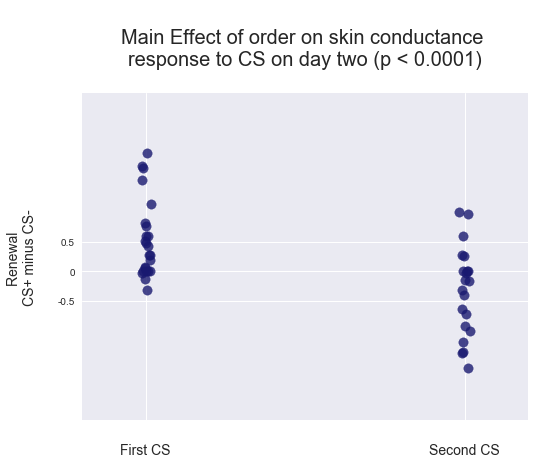

In [22]:
show_order_effects()

In [23]:
renewal['significance']['prediction']  = test_single_relationship(responders_data, 'prediction')


		renewal ~ prediction 

               sum_sq    df          F    PR(>F)
prediction   6.568438   1.0  10.689172  0.002855
Residual    17.205848  28.0        NaN       NaN 



In [24]:
renewal['significance']['contagion']   = test_single_relationship(responders_data, 'contagion')


		renewal ~ contagion 

              sum_sq    df         F    PR(>F)
contagion   0.047000   1.0  0.055464  0.815529
Residual   23.727286  28.0       NaN       NaN 



In [25]:
renewal['significance']['prediction_controlled'] = control_for_order(responders_data, 'prediction')


		renewal ~ C(order) + prediction 

               sum_sq    df          F    PR(>F)
C(order)     6.383237   1.0  15.924754  0.000454
prediction   2.819733   1.0   7.034604  0.013222
Residual    10.822610  27.0        NaN       NaN 



In [26]:
renewal['significance']['contagion_controlled']  = control_for_order(responders_data, 'contagion')


		renewal ~ C(order) + contagion 

              sum_sq    df          F    PR(>F)
C(order)   10.333372   1.0  20.830433  0.000098
contagion   0.248429   1.0   0.500793  0.485216
Residual   13.393914  27.0        NaN       NaN 



In [74]:
def show_relationships(): 
    figure(figsize=[20,5])
    sns.set_style("dark", {'axes.grid' : True})
    subplot(121)
    type_color = 'xkcd:indigo'
    scatter(SCR['contagion'],SCR['renewal'],color='xkcd:white',alpha=1,s=500, label='')
    scatter(SCR['contagion'][counter_balance_info['order'] == False], SCR['renewal'][counter_balance_info['order']  == False],color=type_color,alpha=.8,s=150, label='CS+ first')
    scatter(SCR['contagion'][counter_balance_info['order']  == True], SCR['renewal'][counter_balance_info['order']  == True], color=type_color,alpha=.8, s=100,  label='CS- first', linewidth=3, facecolor='none')

    yticks([-.1,0,.1],[-.1,'',.1])
    xticks([-.1,0,.1],[-.1,0,.1])

    legend( bbox_to_anchor=(.20, 1, 1, -.1), fontsize=13)
    xlabel('Emotional contagion on day one\n CS+ minus CS- at shock offset',fontsize=13, fontweight='bold')
    ylabel('Renewal on day two\n CS+ minus CS-',fontsize=13, fontweight='bold')
    #xlim(-.4,1)
    title('Relationship between emotional contagion and renewal (p < %.1f)\n' 
          %(renewal['significance']['contagion']), fontsize=18, fontweight='bold'); 

    subplot(122)
    type_color = 'xkcd:indigo'
    scatter(SCR['prediction'], SCR['renewal'],color='xkcd:white',alpha=1,s=500, label='')
    #scatter(log_learning[responders == True], log_renewal[responders == True],color='yellow',alpha=1,s=300, label='responders')

    scatter(SCR['prediction'][counter_balance_info['order'] == False], SCR['renewal'][counter_balance_info['order']  == False],color=type_color,alpha=.8,s=150, label='CS+ first')
    scatter(SCR['prediction'][counter_balance_info['order']  == True], SCR['renewal'][counter_balance_info['order']  == True], color=type_color,alpha=.8, s=100,  label='CS- first', linewidth=3, facecolor='none')

    yticks([-.1,0,.1],[-.1,'',.1])
    xticks([-.1,0,.1],[-.1,0,.1])

    xlabel('Predictive learning on day one\n CS+ minus CS- at stimulus onset',fontsize=13, fontweight='bold')
    yticks([-.1,0,.1],['','',''])
    title('\n Relationship between predictive learning and renewal (p < %.3f)\n' 
          %(renewal['significance']['prediction']), fontsize=18, fontweight='bold'); 
    suptitle('STUDY ONE', y =1.15, fontsize=20, fontweight='bold')
    
    savefig('images/day_one_scr_comparision.png')

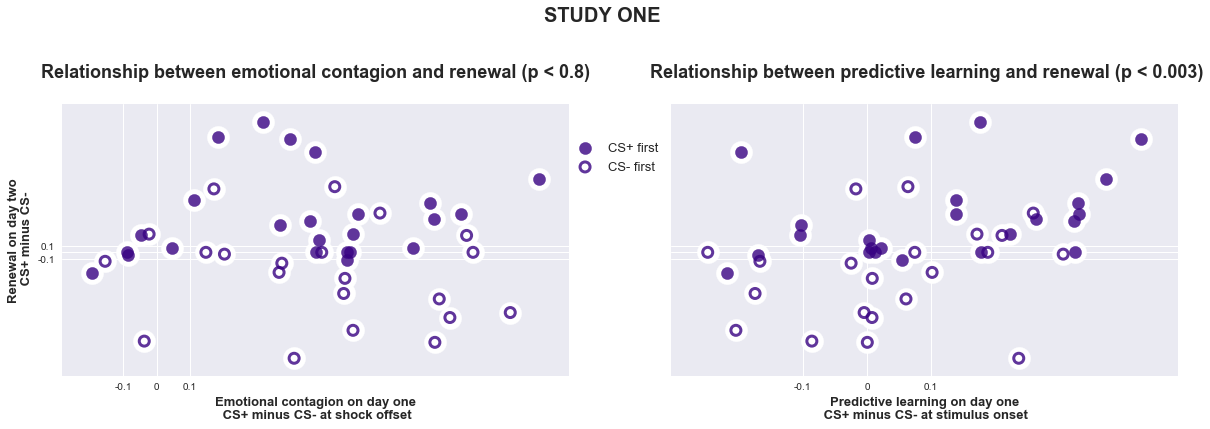

In [75]:
show_relationships()

In [96]:
def partition_analysis(_cond, _rnwl, _title, _figure_name): 
    
    cutoffs = {'1) significance':.05,
               '2) upper_quartile':np.percentile(conditioning['trans_onset']['significe_difference'], 25), 
               '3) upper third': np.percentile(conditioning['trans_onset']['significe_difference'], 33)}
    
    cutoff_keys = cutoffs.keys(); cutoff_keys.sort() 

    cond_sig_on = np.zeros(day_one.nSubjects)
    for i_subject in range(0,day_one.nSubjects): 
        cond_sig_on[i_subject] = scipy.stats.ttest_ind(_cond['positive_stim'][i_subject,:], 
                                                       _cond['negative_stim'][i_subject,:])[1];

    figure(figsize=[20,5])
    sns.set_style("dark", {'axes.grid' : True})

    for i_cutoff in range(len(cutoffs)): 

        subplot(1,3,i_cutoff + 1)
        _i_cut = cutoff_keys[i_cutoff]
        _cutoff = cutoffs[_i_cut]

        con_subs_= find(cond_sig_on < _cutoff)

        tmp_len_p = len(_rnwl['positive_stim'][con_subs_])
        tmp_len_n = len(_rnwl['negative_stim'][con_subs_])
        jitter_p = np.random.randn(tmp_len_p)/100
        jitter_n = np.random.randn(tmp_len_n)/100

        _results_ = scipy.stats.ttest_ind(_rnwl['positive_stim'][con_subs_], _rnwl['negative_stim'][con_subs_])

        scatter(np.zeros(tmp_len_p)+ .3 + jitter_p, _rnwl['positive_stim'][con_subs_],s=300, alpha=1,color='white') 
        scatter(np.zeros(tmp_len_p)+ .3 + jitter_p, _rnwl['positive_stim'][con_subs_],s=100, alpha=.5,color='xkcd:red') 
        scatter(np.zeros(tmp_len_n)+jitter_n, _rnwl['negative_stim'][con_subs_]+ jitter_p,s=300, alpha=1, color='white') 
        scatter(np.zeros(tmp_len_n)+jitter_n, _rnwl['negative_stim'][con_subs_]+ jitter_p,s=100, alpha=.5, color='midnightblue') 
        xlim([-.1,.4])
        xticks([0,.3], ['\nCS-', '\nCS+'], fontsize=15); 
        yticks([0,.5], [0.,.5], fontsize=10); 
        ylabel('Skin Conductance Response\nat first presentation of stimuli on day two')
        title('\n Subjects below %s (p < %.2f) : p < %.4f\n'%(_i_cut, _cutoff, _results_.pvalue), fontsize=15); 
    
    suptitle('Segmenting renewal scores according to how significant %s was for each subject across conditioning on day one'%(_title), 
             fontsize=15, fontweight='bold',y=1.1);
    
    savefig('images/segmentation_analyis_%s_%s.png'%(_title, _figure_name))
    
    return cond_sig_on

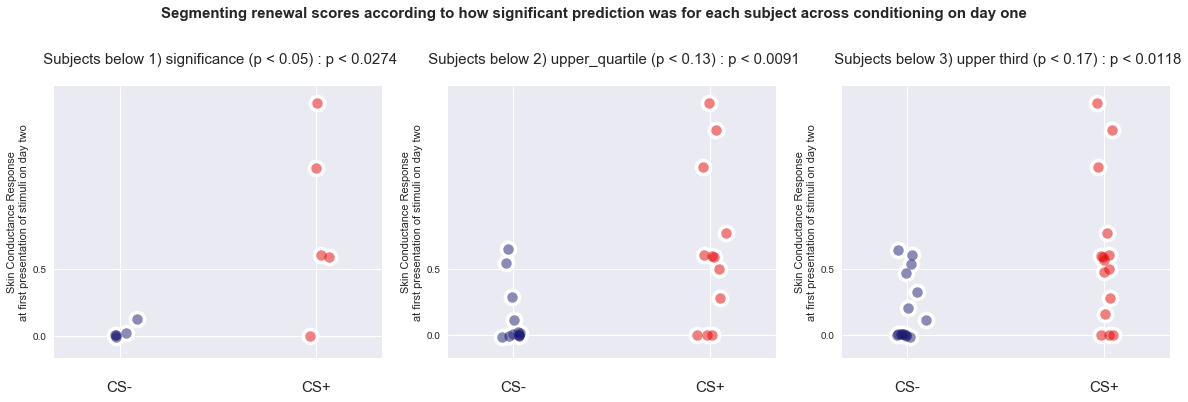

In [97]:
onset_significance = partition_analysis(conditioning['trans_onset'], renewal['trans_onset'], 'prediction', 'study_one')

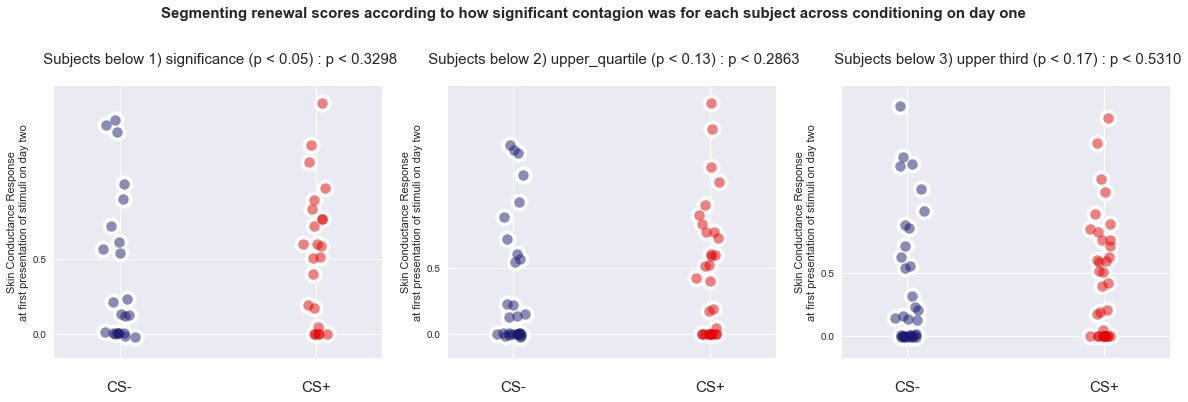

In [98]:
offset_significance = partition_analysis(conditioning['trans_offset'], renewal['trans_onset'], 'contagion', 'study_one')

In [32]:
cond_sig_on = np.zeros(day_one.nSubjects)
for i_subject in range(0,day_one.nSubjects): 
    cond_sig_on[i_subject] = scipy.stats.ttest_ind(conditioning['trans_onset']['positive_stim'][i_subject,:], 
                                                   conditioning['trans_onset']['negative_stim'][i_subject,:])[1];
    
cond_sig_off = np.zeros(day_one.nSubjects)
for i_subject in range(0,day_one.nSubjects): 
    cond_sig_off[i_subject] = scipy.stats.ttest_ind(conditioning['trans_offset']['positive_stim'][i_subject,:], 
                                                   conditioning['trans_offset']['negative_stim'][i_subject,:])[1];

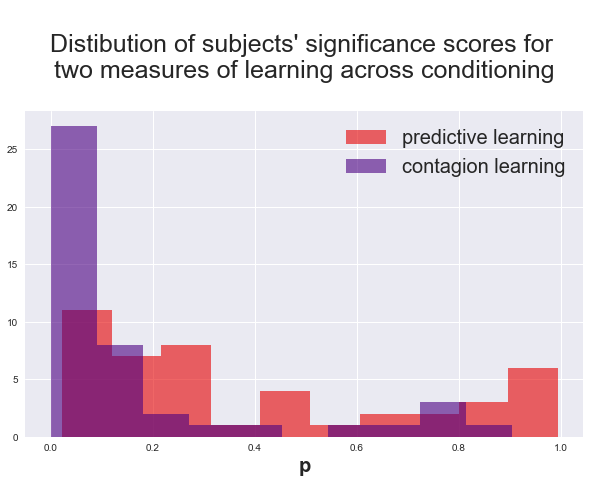

In [33]:
figure(figsize=[10,6])
hist(cond_sig_on, alpha=.6, label='predictive learning', color='xkcd:red')
hist(cond_sig_off, alpha=.6, label='contagion learning', color='indigo'); 
legend(fontsize=20)
title("\nDistibution of subjects' significance scores for \ntwo measures of learning across conditioning\n", fontsize=25); 
xlabel('p', fontweight='bold', fontsize=20); 

In [34]:
self_report, subject_names = behavioral_functions.generate_data_frame(behavioral_data_path)

In [35]:
SCR_all = pandas.DataFrame({'renewal':renewal['trans_onset']['contrast'], 
                            'prediction':conditioning['trans_onset']['learning'], 
                            'order':abs(1-counter_balance_info['order'])}) 

SCR_all['subject_names'] = [day_two.subjectNames[ii][0:4] for ii in range(day_two.nSubjects)]

In [36]:
for ii in range(len(SCR_all)): 
    name = SCR_all.subject_names.values[ii]
    found = 0
    for jj in range(len(self_report)): 
        if name in self_report.index.values[jj]: 
            found = 1
    if found == 0 : 
        missing_subject = ii

In [37]:
SCR_all = SCR_all.drop(missing_subject)
onset_significance_corrected = np.delete(onset_significance, missing_subject)
offset_significance_corrected = np.delete(offset_significance, missing_subject)

In [38]:
tmp_data = {}
indices = [] 
for ii in range(len(SCR_all.keys())): 
    tmp_data[SCR_all.keys()[ii]] = SCR_all[SCR_all.keys()[ii]].values

for ii in range(len(self_report.keys())): 
    tmp_data[self_report.keys()[ii]] = self_report[self_report.keys()[ii]].values

In [39]:
physio_selfreport = pandas.DataFrame.from_dict(tmp_data)

In [40]:
cols = physio_selfreport.columns
cols = cols.map(lambda x: x.replace(' ', '_') if isinstance(x, (str, unicode)) else x)
physio_selfreport.columns = cols

cols = physio_selfreport.columns
cols = cols.map(lambda x: x.replace(':', '') if isinstance(x, (str, unicode)) else x)
physio_selfreport.columns = cols

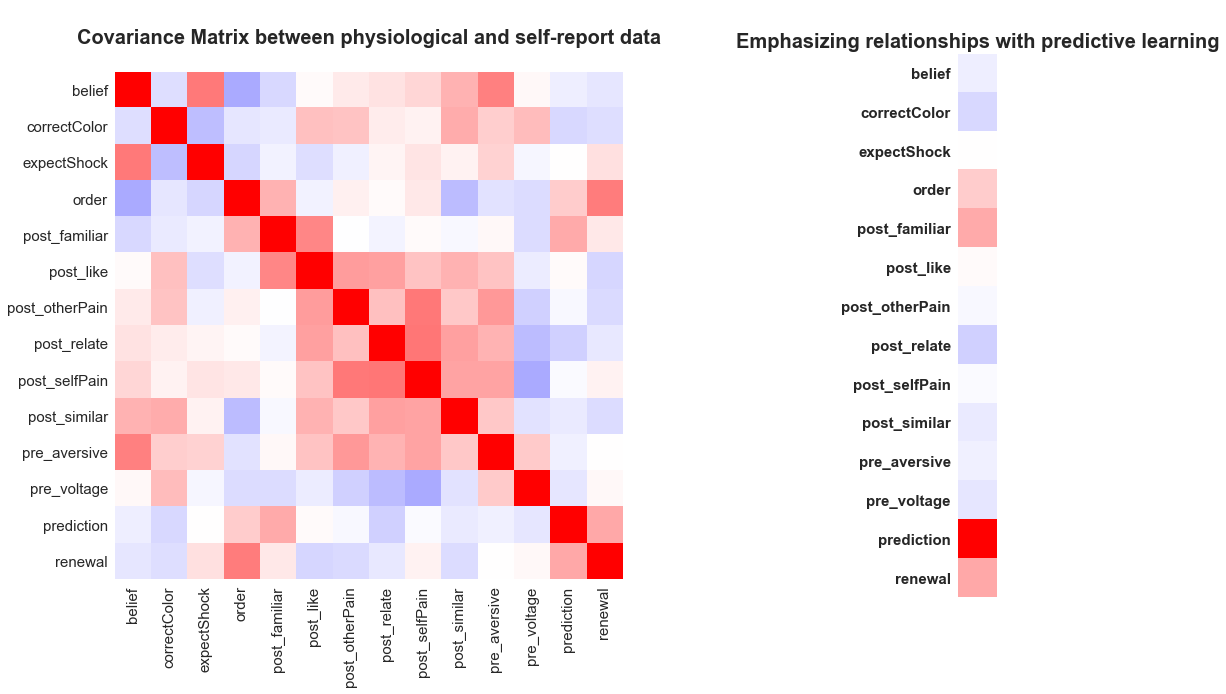

In [88]:
sns.set_style("dark", {'axes.grid' : False})
figure(figsize=[20,10])
subplot(121)
whole_corr = physio_selfreport.corr()
imshow(whole_corr, cmap='bwr', vmax=1, vmin=-1)
yticks(range(0,len(whole_corr.keys())),whole_corr.keys(), fontsize=15); 
xticks(range(0,len(whole_corr.keys())),whole_corr.keys(), rotation=90, fontsize=15); 
title('\nCovariance Matrix between physiological and self-report data\n', fontsize=20, fontweight='bold')
subplot(122)
sns.set_style("dark", {'axes.grid' : False})
imshow(whole_corr[-2:-1].T, cmap='bwr', vmax=1, vmin=-1)
yticks(range(len(whole_corr.keys())),whole_corr.keys(),fontsize=15, fontweight='bold'); 
#colorbar() ; 
xticks([]);
title('\nEmphasizing relationships with predictive learning', fontsize=20, fontweight='bold')
savefig('images/covariace_matrix_study_one.png')

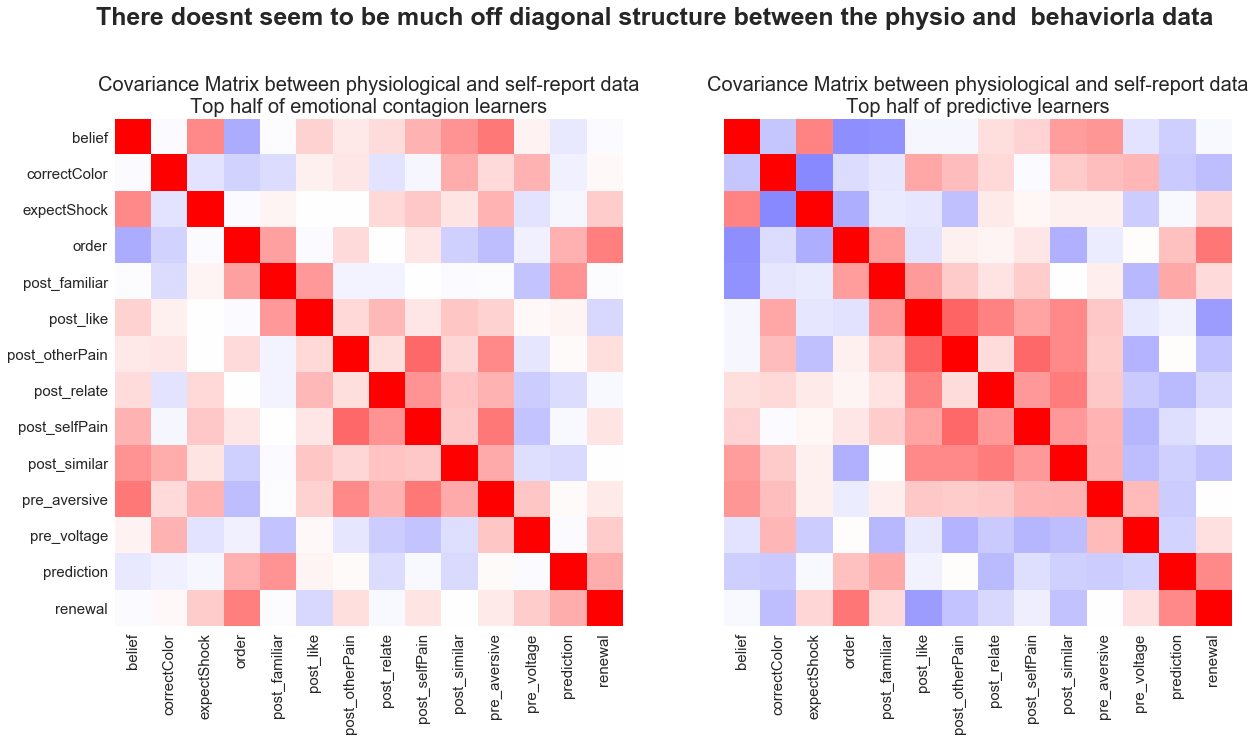

In [42]:
figure(figsize=[20,10])
subplot(121)
full_data_threshhold = physio_selfreport[offset_significance_corrected < offset_significance_corrected.mean(0)  ]
whole_corr = full_data_threshhold.corr()
imshow(whole_corr, cmap='bwr', vmax=1, vmin=-1)
yticks(range(0,len(whole_corr.keys())),whole_corr.keys(), fontsize=15); 
xticks(range(0,len(whole_corr.keys())),whole_corr.keys(), rotation=90, fontsize=15); 
title('\nCovariance Matrix between physiological and self-report data\nTop half of emotional contagion learners', fontsize=20)
subplot(122)
full_data_threshhold = physio_selfreport[onset_significance_corrected<onset_significance_corrected.mean(0)]
sns.set_style("dark", {'axes.grid' : False})
whole_corr = full_data_threshhold.corr()
imshow(whole_corr, cmap='bwr', vmax=1, vmin=-1)
yticks([-1])
xticks(range(0,len(whole_corr.keys())),whole_corr.keys(), rotation=90, fontsize=15); 
title('\nCovariance Matrix between physiological and self-report data\nTop half of predictive learners', fontsize=20)
suptitle('There doesnt seem to be much off diagonal structure between the physio and  behaviorla data', 
         fontweight='bold', fontsize=25,y=1.01);
print '\n'

In [43]:
formula = 'renewal ~ pre_aversive'
model = ols(formula, physio_selfreport).fit()
aov_table = anova_lm(model, typ=2)
print '\n\n', formula, '\n\n', aov_table



renewal ~ pre_aversive 

                 sum_sq    df         F   PR(>F)
pre_aversive   0.000587   1.0  0.000874  0.97656
Residual      28.229751  42.0       NaN      NaN


In [44]:
formula = 'prediction ~ post_familiar'
model = ols(formula, physio_selfreport).fit()
aov_table = anova_lm(model, typ=2)
print '\n\n\t\t', formula, '\n\n', aov_table




		prediction ~ post_familiar 

                 sum_sq    df         F    PR(>F)
post_familiar  0.152491   1.0  5.239257  0.027178
Residual       1.222431  42.0       NaN       NaN
